## Traininig the Inclusive classifier with tf.Keras using data in TFRecord format

**tf.keras Inclusive classifier** This notebooks trains a neural network for the particle classifier using the Inclusive Classifier, using as input the list of recunstructed particles with the low level features + the high level features. Data is prepared from Parquet using Apache Spark, and written into TFRecord format. Data in TFRecord format is read from TensorFlow using tf.data and tf.io in tf.keras.

To run this notebook we used the following configuration:
* *Software stack*: TensorFlow 2.0.0-rc0
* *Platform*: CentOS 7, Python 3.6

In [1]:
import tensorflow as tf
import numpy as np
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import Sequential, Input, Model
from tensorflow.keras.layers import Masking, Dense, Activation, GRU, Dropout, concatenate

tf.version.VERSION
# only needed for TensorFlow 1.x
# tf.enable_eager_execution()

'2.0.0-rc0'

# Configure distributed training using tf.distribute
This notebook shows an example of distributed training with tf.keras using 3 concurrent executions on a single machine.
The test machine has 24 physical cores it has been notes that a serial execution of the training would leave spare capacity. With distributed training we can "use all the CPU on the box". 
- TensorFlow MultiWorkerMirroredStrategy is used to distribute the training.
- Configuration of the workers is done using the OS enviroment variable **TF_CONFIG**.
- **nodes_endpoints** configures the list of machines and ports that will be used. In this example, we use 3 workers on the same machines, you can use this to distribute over multiple machines too
- **worker_number** will be unique for each worker, numbering starts from 0
- Worker number 0 will be the master. 
- You need to run the 3 notebooks for the 3 configured workers at the same time (training will only start when all 3 workers are active) 

In [2]:
# Each worker will have a unique worker_number, numbering starts from 0
worker_number=0

nodes_endpoints = ["localhost:12345", "localhost:12346", "localhost:12347", "localhost:12348"]
number_workers = len(nodes_endpoints)

import os
import json
os.environ['TF_CONFIG'] = json.dumps({
    'cluster': {
        'worker': nodes_endpoints
    },
    'task': {'type': 'worker', 'index': worker_number}
})


In [3]:
strategy = tf.distribute.experimental.MultiWorkerMirroredStrategy()

## Create the Keras model for the inclusive classifier hooking with tf.distribute

In [4]:
# This implements the distributed stratedy for model
with strategy.scope():
    ## GRU branch
    gru_input = Input(shape=(801,19), name='gru_input')
    a = gru_input
    a = Masking(mask_value=0.)(a)
    a = GRU(units=50,activation='tanh')(a)
    gruBranch = Dropout(0.2)(a)
    
    hlf_input = Input(shape=(14), name='hlf_input')
    b = hlf_input
    hlfBranch = Dropout(0.2)(b)

    c = concatenate([gruBranch, hlfBranch])
    c = Dense(25, activation='relu')(c)
    output = Dense(3, activation='softmax')(c)
    
    model = Model(inputs=[gru_input, hlf_input], outputs=output)
    
    ## Compile model
    optimizer = 'Adam'
    loss = 'categorical_crossentropy'
    model.compile(loss=loss, optimizer=optimizer, metrics=["accuracy"] )

W0827 22:06:02.344377 140571229116224 deprecation.py:323] From /local1/lucatests/anaconda3/lib/python3.6/site-packages/tensorflow_core/python/keras/backend.py:3983: where (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [5]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
gru_input (InputLayer)          [(None, 801, 19)]    0                                            
__________________________________________________________________________________________________
masking (Masking)               (None, 801, 19)      0           gru_input[0][0]                  
__________________________________________________________________________________________________
gru (GRU)                       (None, 50)           10650       masking[0][0]                    
__________________________________________________________________________________________________
hlf_input (InputLayer)          [(None, 14)]         0                                            
______________________________________________________________________________________________

## Load test and training data in TFRecord format, using tf.data and tf.io

In [6]:
PATH = "/local3/lucatests/Data/"

# test dataset 
files_test_dataset = tf.data.Dataset.list_files(PATH + "testUndersampled.tfrecord/part-r*", shuffle=False)

# training dataset 
files_train_dataset = tf.data.Dataset.list_files(PATH + "trainUndersampled.tfrecord/part-r*", seed=4242)

In [7]:
# tunable
num_parallel_reads=16

test_dataset = files_test_dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE).interleave(
    tf.data.TFRecordDataset, 
    cycle_length=num_parallel_reads,
    num_parallel_calls=tf.data.experimental.AUTOTUNE)

train_dataset = files_train_dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE).interleave(
    tf.data.TFRecordDataset, cycle_length=num_parallel_reads,
    num_parallel_calls=tf.data.experimental.AUTOTUNE)

In [8]:
# Function to decode TF records into the required features and labels
def decode(serialized_example):
    deser_features = tf.io.parse_single_example(
      serialized_example,
      # Defaults are not specified since both keys are required.
      features={
          'HLF_input': tf.io.FixedLenFeature((14), tf.float32),
          'GRU_input': tf.io.FixedLenFeature((801,19), tf.float32),
          'encoded_label': tf.io.FixedLenFeature((3), tf.float32),
          })
    return((deser_features['GRU_input'], deser_features['HLF_input']), deser_features['encoded_label'])

In [9]:
# use for debugging
# for record in test_dataset.take(1):
#     print(record)

In [10]:
parsed_test_dataset=test_dataset.map(decode, num_parallel_calls=tf.data.experimental.AUTOTUNE)
parsed_train_dataset=train_dataset.map(decode, num_parallel_calls=tf.data.experimental.AUTOTUNE)

In [11]:
# use for debugging
# Show and example of the parsed data
# for record in parsed_test_dataset.take(1):
#    print(record)

In [12]:
# tunable
batch_size = 64 * number_workers

train=parsed_train_dataset.batch(batch_size)
train=train.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
train=train.repeat()
train

<DatasetV1Adapter shapes: (((None, 801, 19), (None, 14)), (None, 3)), types: ((tf.float32, tf.float32), tf.float32)>

In [13]:
num_train_samples=3426083   # there are 3426083 samples in the training dataset

steps_per_epoch=num_train_samples//batch_size
steps_per_epoch

13383

In [14]:
# tunable
test_batch_size = 1024 

test=parsed_test_dataset.batch(test_batch_size)
test=test.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
test=test.repeat()

In [15]:
num_test_samples=856090 # there are 856090 samples in the test dataset

validation_steps=num_test_samples//test_batch_size  
validation_steps

836

## Train the tf.keras model

In [16]:
# train the Keras model

# tunable
num_epochs = 6

# callbacks = [ tf.keras.callbacks.TensorBoard(log_dir='./logs') ]
callbacks = []
    
%time history = model.fit(train, steps_per_epoch=steps_per_epoch, \
                          validation_data=test, validation_steps=validation_steps, \
                          epochs=num_epochs, callbacks=callbacks, verbose=1)


W0827 22:07:10.943064 140571229116224 distribute_coordinator.py:825] `eval_fn` is not passed in. The `worker_fn` will be used if an "evaluator" task exists in the cluster.
W0827 22:07:10.944093 140571229116224 distribute_coordinator.py:829] `eval_strategy` is not passed in. No distribution strategy will be used for evaluation.
W0827 22:07:10.946620 140571229116224 distributed_training_utils.py:1163] ModelCheckpoint callback is not provided. Workers will need to restart training if any fails.


Train for 13383 steps, validate for 836 steps
Epoch 1/6
13383/13383 [==============================] - 7228s 540ms/step - loss: 0.2575 - accuracy: 0.9032 - val_loss: 0.1869 - val_accuracy: 0.9307
Epoch 2/6
13383/13383 [==============================] - 6817s 509ms/step - loss: 0.1815 - accuracy: 0.9336 - val_loss: 0.1522 - val_accuracy: 0.9445
Epoch 3/6
13383/13383 [==============================] - 6722s 502ms/step - loss: 0.1568 - accuracy: 0.9430 - val_loss: 0.1380 - val_accuracy: 0.9500
Epoch 4/6
13383/13383 [==============================] - 6776s 506ms/step - loss: 0.1442 - accuracy: 0.9479 - val_loss: 0.1282 - val_accuracy: 0.9539
Epoch 5/6
13383/13383 [==============================] - 6823s 510ms/step - loss: 0.1375 - accuracy: 0.9505 - val_loss: 0.1266 - val_accuracy: 0.9547
Epoch 6/6
13383/13383 [==============================] - 6813s 509ms/step - loss: 0.1339 - accuracy: 0.9519 - val_loss: 0.1232 - val_accuracy: 0.9556
CPU times: user 1d 13h 32min 17s, sys: 8h 54min 42s, t

In [17]:
PATH="./"
model.save(PATH + "mymodel" + str(worker_number) + ".h5", save_format='h5')

In [20]:
# TF 2.0
# tf.keras.models.save_model(model, PATH + "mymodel" + str(worker_number) + ".tf", save_format='tf')

## Training history performance metrics

<IPython.core.display.Javascript object>


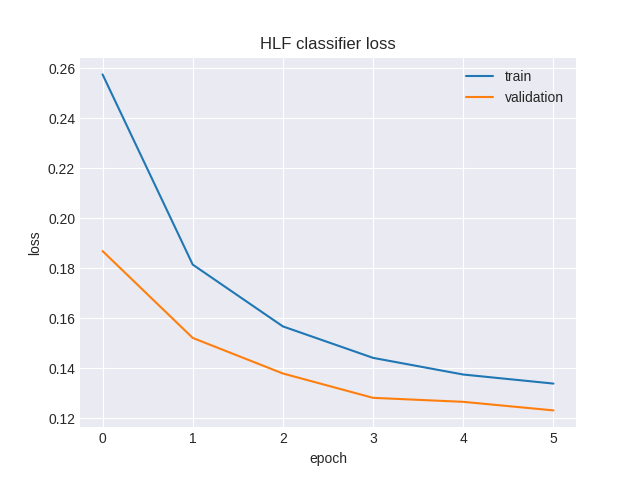

In [21]:
%matplotlib notebook
import matplotlib.pyplot as plt 
plt.style.use('seaborn-darkgrid')
# Graph with loss vs. epoch

plt.figure()
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='validation')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(loc='upper right')
plt.title("HLF classifier loss")
plt.show()

In [ ]:
# Graph with accuracy vs. epoch
%matplotlib notebook
plt.figure()
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='validation')
plt.ylabel('Accuracy')
plt.xlabel('epoch')
plt.legend(loc='lower right')
plt.title("HLF classifier accuracy")
plt.show()

## Model performance metrics
Load the model and plot the ROC and AUC and te confusion matrix using the noteboook  
**4.3a-Model_evaluate_ROC_and_CM.ipynb**